In [9]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc
import scipy


import pymadx

from xcoll_plotting import plot_functions as xcp

print('\nxcoll version: ', xc.__version__)
print('xtrack version: ', xt.__version__)
print('xpart version: ', xp.__version__)
print('xobjects version: ', xo.__version__)

context = xo.ContextCpu() 
seed = 1927034333


xcoll version:  0.6.0rc0
xtrack version:  0.83.1
xpart version:  0.23.0
xobjects version:  0.5.0


In [2]:
# ------------ TRACKING FUNCTIONS ----------------

def change_coordinates_to_b1(df):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df



def reset_coord_cry_tracking(df, twiss, loc_start, loc_name_start, loc_stop_name = 'ip1', turn = 1):
    names = twiss.to_pandas().name.to_numpy()
    idx_start = np.where(names == loc_name_start)[0][0]
    idx_stop = np.where(names == loc_stop_name)[0][0]
    eps =  1e-11
    df = df.iloc[idx_start:idx_stop]
    names = names[idx_start:idx_stop]
    df = df.copy()
    if turn == 1:
        df['s'] = np.where(df['s'] <= end_s - loc_start + eps, end_s - loc_start - df['s'], 2 * end_s - loc_start - df['s'])
    else:
        df = change_coordinates_to_b1(df)
    df['name'] = names
    df = df.sort_values(by="s")
    return df


def CRY_tw(gap, emittance, element, tw):
    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)

    beta_y = tw['bety', element]
    alpha_y = tw['alfy', element]
    #print('beta_y = ', beta_y, 'alpha_y = ', alpha_y)
    return gap*np.sqrt(emittance*beta_y), -gap*alpha_y*np.sqrt(emittance/beta_y)


def track_particle(part, line, tw, turn = 1):
    line.scattering.enable() 
    idx_TCCS = line.element_names.index('tccs.5r3.b2')
    if turn > 1:
        line.track(part, ele_start=idx_TCCS, ele_stop = idx_TCCS, num_turns = turn)
    if part.state > 0:
        start_element =  line.element_names[part.at_element[0]]
        start_loc = line.get_s_position()[part.at_element[0]]
        line.track(part, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=idx_TCCS)
        df1 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), 
                                        tw, loc_start = start_loc, loc_name_start = start_element, loc_stop_name = line.element_names[part.at_element[0]-1], turn = turn)
    else:
        df1 = pd.DataFrame(columns =['s', 'x', 'y', 'py'])
    if part.state >0:
        new_start_element =  line.element_names[part.at_element[0]]
        new_start_loc = line.get_s_position()[part.at_element[0]]
        line.track(part, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_stop=idx_TCCS)
        df2 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), 
                                          tw, loc_start = new_start_loc, loc_name_start = new_start_element, loc_stop_name = line.element_names[part.at_element[0]-1], turn = turn)
    else:
        df2 = pd.DataFrame(columns =['s', 'x', 'y', 'py'])
    line.scattering.disable()
    return df1, df2


# ------------ PLOTTING FUNCTIONS ----------------

def fill_between(ax, df_upper, df_lower):
    if df_upper.empty or df_lower.empty:
        return
    if len(df_upper) > len(df_lower):
        idx = len(df_upper) - len(df_lower)
        df1 = df_upper.iloc[idx:]
        df2 = df_lower
    else:
        idx = len(df_lower) - len(df_upper)
        df1 = df_upper
        df2 = df_lower.iloc[idx:]

    ax.fill_between(df1['s'], df1['y'], df2['y'], color='blue', alpha=0.3)

def get_jaw(ax, name, length, tw, end_s, hgap_L, angle = 90, hgap_R = None, plot_skew = False,  color = None):
    
    if (plot_skew or angle == 90) and angle != 0:
            if color is None:
                color = 'k' if angle == 90 else 'grey'
            s_centre = end_s - tw['s', name]
            sstart  = s_centre - length/2
            send    = s_centre + length/2
            w       = send-sstart
            top_lim = plt.ylim()[1]*2
            bot_lim = plt.ylim()[0]*2

            if hgap_L is not None:
                h       = top_lim - hgap_L * np.sin(np.deg2rad(angle))
                jaw = matplotlib.patches.Rectangle((sstart, hgap_L), w, h, angle=0.0, 
                                                        fc=color, ec=color, zorder=10)
                ax.add_patch(jaw)
            
            if hgap_R is not None:
                h = hgap_R  * np.sin(np.deg2rad(angle)) - bot_lim 
                jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                                    fc=color, ec=color, zorder=10)
                ax.add_patch(jaw)

def convert_mm_to_m(val):
    return val * 1e-3


In [3]:
# -------------- CONSTANT PARAMETERS -----------------
beam =  2 
plane = 'V' 
emittance_n = 3.5e-6
layout_file = "../input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)


TCCP_bending_angle = 6921.3e-6
TCCS_bending_angle = 50e-6
TCCP_length = 0.070
TARGET_length =  0.005
TCCS_length = 0.004

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TFT_name = 'tft.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'

TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCP_loc_abs  = 6653.2543  #6653.3 #6655
PIX1_loc_abs = 6652.7039
PIX2_loc_abs = 6652.6929
PIX3_loc_abs = 6652.6819
TFT_loc_abs = 6652.114

pymadx.Tfs.Load> normal file


In [6]:
# -------------- SETTABLE PARAMETERS -----------------

coll_file = './HL_relaxed.yaml'
#coll_file = './input_files/colldbs/TWOCRYST_colldb_450GeV.yaml'
#line_file = './MadX/2024/track_injection_b2.json'
line_file = './opt_round_150_1500_optphases_b2_patched.json'
#line_file = './MadX/2025_new/flat_top/track_flat_top_b2.json'

part_energy = 7000e9

ignore_crystals = True

In [10]:
# ---------------- BUILD LINE ----------------

line = xt.Line.from_json(line_file)
if part_energy is not None:
    line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                q0=1, mass0=xt.PROTON_MASS_EV)
print(f'\nParticle energy: {float(line.particle_ref.p0c)/1e9:} GeV\n')
energy = line.particle_ref.p0c[0]
beta_rel = line.particle_ref.beta0[0]
gamma = line.particle_ref.gamma0[0]
emittance = emittance_n/(beta_rel*gamma)


dp = 1.92e-10 
pot_crit = 21.34
eta = 0.9
bending_radius = TCCS_length/TCCS_bending_angle
Rcrit = energy/(2*np.sqrt(eta)*pot_crit) * (dp/2)
TCCS_critical_angle = np.sqrt(2*eta*pot_crit/energy)*(1 - Rcrit/bending_radius)


end_s = line.get_length()


TCCS_loc = end_s - TCCS_loc_abs
TCCP_loc = end_s - TCCP_loc_abs
TARGET_loc = end_s - (TCCP_loc_abs + 0.07/2 + 0.005/2)
PIX1_loc = end_s - PIX1_loc_abs
PIX2_loc = end_s - PIX2_loc_abs
PIX3_loc = end_s - PIX3_loc_abs
TFT_loc = end_s - TFT_loc_abs
TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
line.insert_element(at_s=TCCS_loc - TCCS_length/2, element=xt.Marker(), name=TCCS_name+'_exit')
line.insert_element(at_s=TCCS_loc + TCCS_length/2, element=xt.Marker(), name=TCCS_name+'_entry')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc - TCCP_length/2, element=xt.Marker(), name=TCCP_name+'_exit')
line.insert_element(at_s=TCCP_loc + TCCP_length/2, element=xt.Marker(), name=TCCP_name+'_entry')
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name+'_1')
line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_1' + '_aper')
line.insert_element(at_s=PIX2_loc, element=xt.Marker(), name=PIXEL_name+'_2')
line.insert_element(at_s=PIX2_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_2' + '_aper')
line.insert_element(at_s=PIX3_loc, element=xt.Marker(), name=PIXEL_name+'_3')
line.insert_element(at_s=PIX3_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_3' + '_aper')
line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)


colldb = xc.CollimatorDatabase.from_yaml(coll_file, beam=beam, ignore_crystals=ignore_crystals)
colldb.install_everest_collimators(line = line,verbose=True)

# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)

df_apertures = xcp.load_apertures(line)
df_apertures = change_coordinates_to_b1(df_apertures)

# Build the tracker
line.build_tracker()

speed = line.particle_ref._xobject.beta0[0]*scipy.constants.c
harmonic_number = 35640
voltage = 12e6/len(line.get_elements_of_type(xt.Cavity)[1])
frequency = harmonic_number * speed /line.get_length()
for side in ['l', 'r']:
    for cell in ['a','b','c','d']:
        line[f'acsca.{cell}5{side}4.b2'].voltage = voltage
        line[f'acsca.{cell}5{side}4.b2'].frequency = frequency  
tw = line.twiss()

Loading line from dict:   0%|          | 0/88125 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 7000.0 GeV



Slicing line:   0%|          | 0/88125 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88128 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88130 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88132 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88134 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88136 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88139 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88142 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88145 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88148 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/88151 [00:00<?, ?it/s]

Installing tcp.6r3.b2           as EverestCollimator
Installing tcsg.b5r7.b2         as EverestCollimator
Installing tcla.7l3.b2          as EverestCollimator
Installing tcl.6l5.b2           as EverestCollimator
Installing tcspm.6l7.b2         as EverestCollimator
Installing tctpv.6r1.b2         as EverestCollimator
Installing tclpx.4l1.b2         as EverestCollimator
Installing tcl.6l1.b2           as EverestCollimator
Installing tdisb.a4r8.b2        as EverestCollimator
Installing tcla.a6l7.b2         as EverestCollimator
Installing tcla.6l3.b2          as EverestCollimator
Installing tcsg.a5r7.b2         as EverestCollimator
Installing tcsg.b5l7.b2         as EverestCollimator
Installing tcp.d6r7.b2          as EverestCollimator
Installing tcsg.a4l7.b2         as EverestCollimator
Installing tcla.b6l7.b2         as EverestCollimator
Installing tcspm.b4r7.b2        as EverestCollimator
Installing tclib.6l8.b2         as EverestCollimator
Installing tctpv.6r5.b2         as EverestColl

Slicing line:   0%|          | 0/88153 [00:00<?, ?it/s]


Aperture model check after introducing collimators:


Checking aperture:   0%|          | 0/88103 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Compiling ContextCpu kernels...


4c5d6429aed74c669b581c567496ae04.c: In function 'EverestCollimator_track_local_particle':
4c5d6429aed74c669b581c567496ae04.c:17051:42: warning: 'cg' may be used uninitialized in this function [-Wmaybe-uninitialized]
17051 |         XYShift_single_particle(part, -cg->jaw_RU, 0);
      |                                        ~~^~~~~~~~
4c5d6429aed74c669b581c567496ae04.c:22418:24: note: 'cg' was declared here
22418 |     CollimatorGeometry cg;
      |                        ^~
4c5d6429aed74c669b581c567496ae04.c:20092:17: warning: 'coll' may be used uninitialized in this function [-Wmaybe-uninitialized]
20092 |                 mcs(everest, part, rlen, pc, edge_check);
      |                 ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4c5d6429aed74c669b581c567496ae04.c:22417:21: note: 'coll' was declared here
22417 |     EverestCollData coll;
      |                     ^~~~


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


8de605bb398b4a94955094ac1ccca958.c: In function 'EverestCollimator_track_local_particle':
8de605bb398b4a94955094ac1ccca958.c:17055:42: warning: 'cg' may be used uninitialized in this function [-Wmaybe-uninitialized]
17055 |         XYShift_single_particle(part, -cg->jaw_RU, 0);
      |                                        ~~^~~~~~~~
8de605bb398b4a94955094ac1ccca958.c:22422:24: note: 'cg' was declared here
22422 |     CollimatorGeometry cg;
      |                        ^~
8de605bb398b4a94955094ac1ccca958.c:20096:17: warning: 'coll' may be used uninitialized in this function [-Wmaybe-uninitialized]
20096 |                 mcs(everest, part, rlen, pc, edge_check);
      |                 ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
8de605bb398b4a94955094ac1ccca958.c:22421:21: note: 'coll' was declared here
22421 |     EverestCollData coll;
      |                     ^~~~


Done compiling ContextCpu kernels.


In [12]:
# ---------------- SET COLLIMATORS ----------------

line.collimators.assign_optics()

"""for n in colldb.collimator_names:
   if line[n].angle != 0:
      line[n].gap = 40
"""
#line[TCLA_name].gap =  #8


TCCP_gap = 40.0
TARGET_gap = 40.0
TCCS_gap = 5.0

if not ignore_crystals:
   line[TCCS_name].gap = TCCS_gap
   line[TCCS_name].align_to_beam_divergence()
   line[TCCP_name].gap = TCCP_gap
   line[TCCP_name].align_to_beam_divergence()
   line[TARGET_name].gap = TARGET_gap


df_colls = pd.DataFrame(columns=['name', 'angle', 'gap', 'jaw_L', 'jaw_R', 'length'])
for n in colldb.collimator_names:
   if  line[n].__class__.__name__ != 'EverestCrystal':
      df = pd.DataFrame(data = [[n, line[n].angle, line[n].gap, line[n].jaw_L, line[n].jaw_R, line[n].length]], columns=['name', 'angle', 'gap', 'jaw_L', 'jaw_R', 'length'])
      df_colls = pd.concat([df_colls, df], ignore_index=True)

impacts = xc.InteractionRecord.start(line=line)

In [13]:
# ---------------- INITIALIZE PARTICLES ----------------

idx_TCCS = line.element_names.index(TCCS_name)

CRY_kick = TCCS_bending_angle if ignore_crystals else 0

cry_part_chann = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            x = 0,
                            px = 0,
                            y = CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[0],
                            py = CRY_tw(TCCS_gap, emittance, TCCS_name , tw)[1] + CRY_kick,
                            #y = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[0],
                            #py = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[1] + CRY_kickk,
                            at_element = idx_TCCS,
                            particle_id = 0,
                            _context=context)

cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0 = 1, mass0=xp.PROTON_MASS_EV,
                        x = 0,
                        px = 0,
                        y = CRY_tw(TCCS_gap, emittance, TCCS_name , tw)[0],
                        py = CRY_tw(TCCS_gap, emittance, TCCS_name , tw)[1] + CRY_kick + TCCS_critical_angle,
                        #y = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[0],
                        #py = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[1] + CRY_kickk + TCCS_critical_angle,
                        at_element = idx_TCCS,
                        particle_id = 1,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0 = 1, mass0=xp.PROTON_MASS_EV,
                        x = 0,
                        px = 0,
                        y = CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[0],
                        py = CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[1] + CRY_kick - TCCS_critical_angle,
                        #y = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[0],
                        #|py = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[1] + CRY_kickk - TCCS_critical_angle,
                        at_element = idx_TCCS,
                        particle_id = 2,
                        _context=context)

if seed is not None:
    cry_part_chann._rng_s1, cry_part_chann._rng_s2, cry_part_chann._rng_s3, cry_part_chann._rng_s4 = seed, seed+1, seed+2, seed+3
    cry_part_chann_upper._rng_s1, cry_part_chann_upper._rng_s2, cry_part_chann_upper._rng_s3, cry_part_chann_upper._rng_s4 = seed, seed+1, seed+2, seed+3
    cry_part_chann_lower._rng_s1, cry_part_chann_lower._rng_s2, cry_part_chann_lower._rng_s3, cry_part_chann_lower._rng_s4 = seed, seed+1, seed+2, seed+3

In [14]:
# ---------------- TRACKING ----------------

turn_to_track = 1

df_chann_L, df_chann_R = track_particle(cry_part_chann, line, tw, turn_to_track)
df_chann_upper_L, df_chann_upper_R = track_particle(cry_part_chann_upper, line, tw,turn_to_track)
df_chann_lower_L, df_chann_lower_R = track_particle(cry_part_chann_lower, line, tw, turn_to_track)

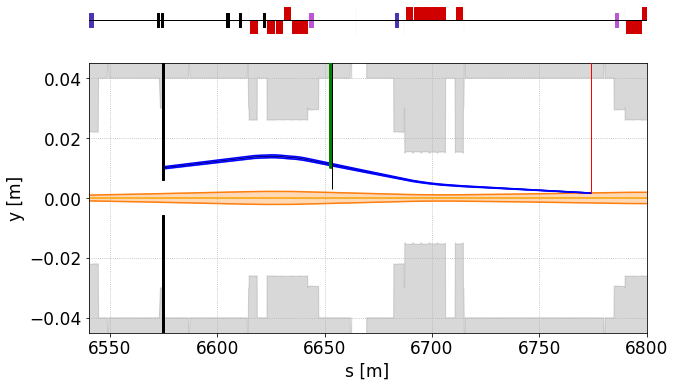

In [79]:
#%matplotlib notebook
# ---------------- PLOT ----------------

start, stop = 6540,6800  # 0, end_s#19000, 21000 #4000, 6000 # 6540,6777  #6540,6777 #6773.8,6774 #6640,6777 #0, end_s #6740,6777
n_env = 5
plot_cry_envelope = True if ignore_crystals else False
figsize = (10, 6)#(25,6)
plot_skew = False

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=figsize)
pymadx.Plot._SetMachineAxesStyle(ax[0])
pymadx.Plot._DrawMachineLattice(ax[0], layout_data_object)
ax[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)


df_ref = change_coordinates_to_b1(tw.to_pandas())
ax[1].plot(df_ref["s"],df_ref["y"],color="orange")
ax[1].plot(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']) + df_ref['y'], color='C1')
ax[1].plot(df_ref["s"],-n_env*np.sqrt(emittance*df_ref['bety'])+ df_ref['y'], color='C1')
ax[1].fill_between(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']) + df_ref['y'], -n_env*np.sqrt(emittance*df_ref['bety'])+ df_ref['y'], color='C1', alpha=0.3)

ax[1].plot(df_chann_L["s"],df_chann_L["y"], color='darkblue')
ax[1].plot(df_chann_R["s"],df_chann_R["y"], color='darkblue')

if plot_cry_envelope:
    ax[1].plot(df_chann_upper_L["s"],df_chann_upper_L["y"], color='blue')
    ax[1].plot(df_chann_upper_R["s"],df_chann_upper_R["y"], color='blue')
    ax[1].plot(df_chann_lower_L["s"],df_chann_lower_L["y"], color='blue')
    ax[1].plot(df_chann_lower_R["s"],df_chann_lower_R["y"], color='blue')
    fill_between(ax[1], df_chann_upper_R, df_chann_lower_R)
    fill_between(ax[1], df_chann_upper_L, df_chann_lower_L)

ax[1].set_xlabel('s [m]',  fontsize=17)
ax[1].set_xlim(start, stop)
ax[1].set_ylim(-0.045, 0.045)
ax[1].set_ylabel('y [m]',  fontsize=17)
ax[1].grid(linestyle=':')
ax[1].tick_params(axis='both', which='major', labelsize=17)
xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), ax[1], "v")
   
get_jaw(ax[1], PIXEL_name+ '_1', 0.06, tw, end_s, hgap_L = 0.010, color='green')
get_jaw(ax[1],TFT_name, 0.06,  tw, end_s, hgap_L = 0.010, color='green')
#get_jaw(ax[1],TCCP_name, TCCP_length, tw, end_s, hgap_L = float(df_chann_L[df_chann_L['name'] == TCCP_name ]['y']), color = 'r')
get_jaw(ax[1],TCCS_name, TCCS_length, tw, end_s, hgap_L= CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[0], color = 'r')
for n in df_colls.name:
    coll = df_colls[df_colls['name'] == n]
    #if coll['angle'].values[0] == 90:
    get_jaw(ax[1],n, coll.length.values[0], tw, end_s, angle = coll.angle.values[0],  hgap_L = coll.jaw_L.values[0], hgap_R = coll.jaw_R.values[0], plot_skew = plot_skew)

plt.show()


In [80]:
tolerance = 1e-9 

In [81]:
df_ref_TCLA = df_ref[(df_ref['s'] >=  min(df_chann_L.s)- tolerance) & (df_ref['s'] <= max(df_chann_L.s))]

In [83]:
hgap = []
tolerance = 1e-9 
sigmas = []
ss = []
n_sigmas = []
for s in df_chann_L.s.unique():
    df_ref_TCLA_loc = df_ref_TCLA[np.isclose(df_ref_TCLA.s, s, atol=tolerance)]
    y_chann = df_chann_L[np.isclose(df_chann_L.s, s, atol=tolerance)].y.values[0]
    betay = df_ref_TCLA_loc['bety'].values[0]
    y_ref = df_ref_TCLA_loc['y'].values[0]
    sigma =  np.sqrt(emittance*betay)
    hgap.append(y_chann - y_ref)
    sigmas.append(sigma)
    ss.append(s)
    n_sigmas.append((y_chann - y_ref)/sigma)

df_hgap = pd.DataFrame(data = list(zip(ss, hgap, sigmas, n_sigmas)), columns=['s', 'hgap', 'sigma', 'n_sigma'])


In [84]:
df_hgap

,s,hgap,sigma,n_sigma
0,6574.720796,0.010075,0.000291,34.565664
1,6574.960796,0.010095,0.000292,34.548765
2,6575.480796,0.010140,0.000294,34.512237
3,6582.420796,0.010734,0.000315,34.037488
4,6582.720796,0.010760,0.000316,34.017547
...,...,...,...,...
241,6765.720796,0.001953,0.000314,6.226801
242,6772.720796,0.001682,0.000329,5.106227
243,6773.020796,0.001671,0.000330,5.060484
244,6773.940800,0.001635,0.000332,4.921261


In [97]:
0.010074641271144541/ 0.00029146384440082454

34.5656638539694

Text(6574.220795520014, 0.015, 'TCLA')

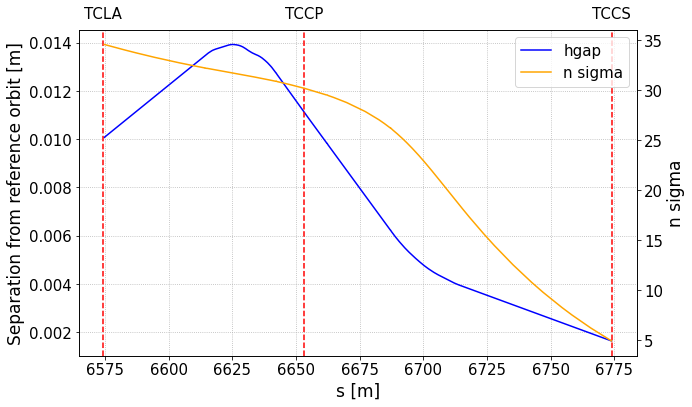

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot on the primary y-axis
line1, = ax.plot(df_hgap['s'], df_hgap['hgap'], color='blue', label='hgap')

# Plot on the secondary y-axis
ax2 = ax.twinx()
line2, = ax2.plot(df_hgap['s'], df_hgap['n_sigma'], color='orange', label='n sigma')

# Grid and labels
ax.grid(linestyle=':')
ax.set_xlabel('s [m]', fontsize=17)
ax.set_ylabel('Separation from reference orbit [m]', fontsize=17)
ax2.set_ylabel('n sigma', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, fontsize=15, loc='upper right')  # Adjust loc as needed
ax.axvline(x=end_s-TCCS_loc, color='red', linestyle='--', label='TCCS')
ax.axvline(x=end_s-TCLA_loc, color='red', linestyle='--', label='TCCP')
ax.axvline(x=end_s-TCCP_loc, color='red', linestyle='--', label='TCCP')
ax.text(end_s-TCCP_loc, 0.015,"TCCP", horizontalalignment='center', fontsize=15)
ax.text(end_s-TCCS_loc, 0.015, "TCCS", horizontalalignment='center', fontsize=15)
ax.text(end_s-TCLA_loc, 0.015, "TCLA", horizontalalignment='center', fontsize=15)


In [15]:
def calc_nsigma(df_twiss, df_chann, emittance_phy, obj_name, add_offset = 0):

    s_centre = float(df_twiss[df_twiss["name"] == obj_name]['s'])
    hgap =  df_chann[df_chann['s'] == s_centre]['y'].iloc[0]  - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0] - add_offset
    beta_y = float(df_twiss[df_twiss["name"] == obj_name]['bety'])
    sigma =  np.sqrt(emittance_phy*beta_y)

    #five_sig_gap  = df_twiss[df_twiss['s'] == s_centre]['n_sigma_y'].iloc[0] - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    #print('check: ', five_sig_gap/sigma)
    
    return hgap/sigma, hgap 

In [21]:
upper_sig, upper_m = calc_nsigma(df_ref, df_chann_upper_L, emittance, TCCP_name)
central_sig, central_m =  calc_nsigma(df_ref, df_chann_L, emittance, TCCP_name)
lower_sig, lower_m =  calc_nsigma(df_ref, df_chann_lower_L, emittance, TCCP_name)

print(f'\nUpper: {upper_sig:.2f} sigma, {upper_m*1e3:.2f} mm')
print(f'Central: {central_sig:.2f} sigma, {central_m*1e3:.2f} mm')
print(f'Lower: {lower_sig:.2f} sigma, {lower_m*1e3:.2f} mm')
print(f'\nDimesion of the 5 sigma channelled spot (upper-lower): {(upper_m-lower_m)*1e3:.2f} mm   \tCrystal height: 2 mm')
print(f'Center the spot in the crystal: [{central_m*1e3-1:.2f},{central_m*1e3+1:.2f}] mm')
beta_y = float(df_ref[df_ref["name"] == TCCP_name]['bety'])
sigma =  np.sqrt(emittance*beta_y)
print(f'Jaw sigma in order to center: {(central_m-0.001)/sigma:.1f}')


Upper: 11.38 sigma, 16.38 mm
Central: 10.12 sigma, 14.57 mm
Lower: 8.86 sigma, 12.75 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 3.63 mm   	Crystal height: 2 mm
Center the spot in the crystal: [13.57,15.57] mm
Jaw sigma in order to center: 9.4
